In [1]:
%matplotlib inline
import pandas as pn
import matplotlib.pyplot as plt
import numpy as np
import active_subspaces as ac
from HIV_model import *

#1. HIV Model

Text(0.5, 1.0, 'Representative Solutions for T(t)')

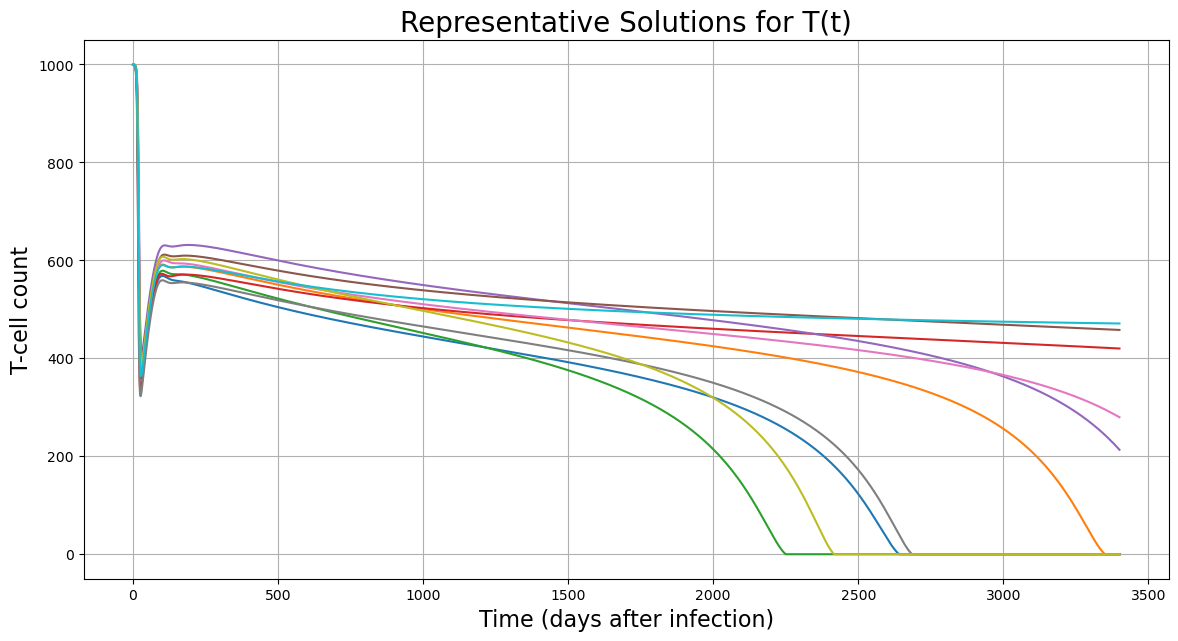

In [2]:
# Nominal Parameter Values
nominal = np.array([10, .15, 5, .2, 55.6, 3.87e-3, 1e-6, 4.5e-4, 7.45e-4, 5.22e-4, 3e-6,\
    3.3e-4, 6e-9, .537, .285, 7.79e-6, 1e-6, 4e-5, .01, .28, .05, .005, .005, .015, 2.39,\
    3e-4, .97])

#Lower and upper parameter limits
xl = .975*nominal; xu = 1.025*nominal

#Number of random points to use
N = 20

#Normalized parameter values
XX = np.random.uniform(-1, 1, (N, len(xl)))
#Unnormalized parameter values
p = .5*((np.diag(xu - xl)).dot(XX.T) + xu[:,None] + xl[:,None]).T

#Times at which to find the quantity of interest initially
times = np.linspace(1, 3400, 3400)

#Each row of f contains T(t) for t in times using parameters in the corresponding row of p
f = Tcells(p, times)

#Plot the first 10 solutions as example solutions
plt.figure(figsize=(14, 7))
for i in range(10): plt.plot(times, f[i])
plt.grid(True); plt.xlabel('Time (days after infection)', fontsize=16)
plt.ylabel('T-cell count', fontsize=16)
plt.title('Representative Solutions for T(t)', fontsize=20)

## 2. Compute the gradient using finite difference method

In [3]:
times = np.array([5,15,24])

#Array of gradient values
df = np.empty((N, 27*len(times)))
#Step sizes to use for finite differences
h = 1e-7*(xu - xl).reshape((1, len(xl)))/2.

times = np.array([5,15,24])
#Approximate gradients
for i in range(len(times)):
    df[:,27*i:27*(i+1)] = ac.gradients.finite_difference_gradients(p,\
        lambda x: Tcells(x, np.linspace(1, times[i], times[i]))[:,-1], h)
    df[:,27*i:27*(i+1)] *= .5*(xu - xl).reshape((1, len(xl)))

# 3. DerSHAP - Sensitivity Analysis

In [4]:
def DerSHAP(df):
    """
    Input: 
        df:d-by-1 array, this is the gradient vector
    Output: 
        norm_shap:  normalized DerSHAP values
    Parameters:
        C: d-by-d matrix, this is the gradient matrix
        shap: d-by-1 array, this is the DerSHAP values array
        norm_shap: d-by 1 array, this is the normalized DerSHAP values
    """
    C = np.dot(df.transpose(), df)
    C = abs(C)
    shap = np.zeros(len(C))
    for ii in range(len(C)):
        shap[ii] = 0.5*C[ii,ii]
        temp = 0
        for jj in range(len(C[0])):
            temp = 0.5 * C[ii,jj]
        shap[ii] += temp
    norm_shap = [shap[ii]/sum(shap) for ii in range(len(shap))]
    return norm_shap

[0.006 0.    0.005 0.001 0.003 0.235 0.    0.033 0.    0.001 0.    0.005
 0.    0.223 0.001 0.    0.    0.    0.007 0.058 0.    0.    0.    0.005
 0.21  0.    0.208]


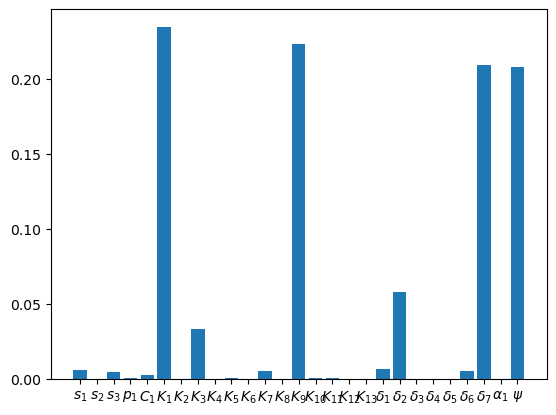

In [5]:
df=df[:,27*2:27*3] # Compute the subspace corresponding to t = 24 days
norm_shap = DerSHAP(df)
in_labels = [r'$s_1$', r'$s_2$', r'$s_3$', r'$p_1$', r'$C_1$', r'$K_1$', r'$K_2$', r'$K_3$',r'$K_4$', r'$K_5$', r'$K_6$', r'$K_7$', r'$K_8$', r'$K_9$', r'$K_{10}$',\
             r'$K_{11}$', r'$K_{12}$', r'$K_{13}$', r'$\delta_1$', r'$\delta_2$',r'$\delta_3$', r'$\delta_4$', r'$\delta_5$', r'$\delta_6$', r'$\delta_7$',\
             r'$\alpha_1$', r'$\psi$']
plt.bar(in_labels, norm_shap)
plt.savefig("HIV_model.pdf")
print(np.round(norm_shap,3))